In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn

numpy = lambda x : x.detach().cpu().numpy().squeeze()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import pyrtools as pt
import plenoptic as po

%load_ext autoreload
%autoreload 2

In [93]:
class LG(nn.Module):
    """


    """
    def __init__(self, cmplx=True):
        super(LG, self).__init__()

        if cmplx:
            self.L1 = po.simul.Steerable_Pyramid_Freq([256, 256], order=1, height=5, is_complex=True)
            self.G1 = po.simul.non_linearities.rectangular_to_polar_dict
        else:
            self.L1 = po.simul.Steerable_Pyramid_Freq([256, 256], order=1, height=5)
            self.G1 = po.simul.non_linearities.local_gain_control
            
    def forward(self, image, get_list=True):

        self.activation1 = self.L1(image)
        
        self.norm1, self.direction1 = self.G1(self.activation1, residuals=False)

        if get_list:
            return [k for k in self.norm1.values()]
        else:
            return self.norm1

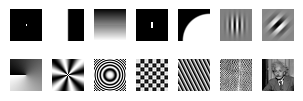

In [25]:
stimuli = po.make_basic_stimuli(32)
pt.imshow(numpy(stimuli), title=None, col_wrap=7);

In [3]:
%debug

> /Users/pe/Drive/_Code/2_SignalProcessing/plenoptic/plenoptic/tools/data.py(81)make_basic_stimuli()
     79     stimuli = torch.cat(
     80         [torch.tensor(s, dtype=torch.float32, requires_grad=requires_grad).unsqueeze(0).unsqueeze(0) for s in stim],
---> 81         dim=0)
     82 
     83     return stimuli



ipdb>  [s.shape for s in stim]


[(32, 32), (32, 32), (32, 32), (32, 32), (32, 32), (32, 32), (32, 32), (32, 32), (32, 32), (32, 32), (256, 256), (256, 256), (256, 256), (32, 32), (256, 256)]


ipdb>  q


In [95]:
lgc = LG(cmplx=True)
yc = lgc(stimuli, get_list=False)

lg = LG(cmplx=False)
y = lg(stimuli, get_list=False)

In [96]:
y[1, 1].shape, yc[1, 1].shape

(torch.Size([15, 1, 64, 64]), torch.Size([15, 1, 128, 128]))

In [97]:
lg.activation1[1,1].shape, lgc.activation1[1,1].shape

(torch.Size([15, 1, 128, 128]), torch.Size([15, 1, 128, 128, 2]))

In [131]:
# pt.pyrshow(po.convert_pyrshow(lg.direction1, -1, 0), zoom=.5, plot_complex='polar', col_wrap=4);
# pt.pyrshow(po.convert_pyrshow(lgc.direction1, -1, 0), zoom=.5, plot_complex='polar', col_wrap=4);

In [132]:
# pt.pyrshow(po.convert_pyrshow(lg.norm1, -1, 0), zoom=.5, plot_complex='polar', col_wrap=4);
# pt.pyrshow(po.convert_pyrshow(lgc.norm1, -1, 0), zoom=.5, plot_complex='polar', col_wrap=4);

In [ ]:
# TODO

# compare ReLU to:
# amplitude * ReLU(cos(phase))
# amplitude * Conv(phase, [-pi/2, pi/2])

# return as one big tensor with all upsampled

# video display

In [158]:
def dict_apply(dict_in, function, **kwargs):
    dict_out = {}

    for key in dict_in.keys():
        dict_out[key] = function(dict_in[key], **kwargs)

    return dict_out

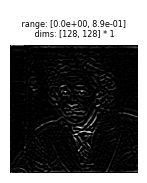

In [179]:
rect_a = dict_apply(lg.activation1, ReLU)
# pt.pyrshow(po.convert_pyrshow(rect_a, -1, 0), zoom=.5, col_wrap=4);
pt.imshow(po.to_numpy(rect_a[1,1][ -1, 0]));

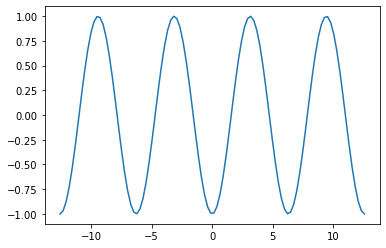

In [237]:
xs = np.linspace(-4* np.pi, 4 * np.pi, 100)
plt.plot(xs, -np.cos(xs))

In [238]:
def mask_phase(xs):
    xs_mod = xs % (2*np.pi)
    l_pi2 = xs_mod < np.pi/2
    m_3pi2 = xs_mod > 3*np.pi/2
    return xs * (l_pi2 + m_3pi2)

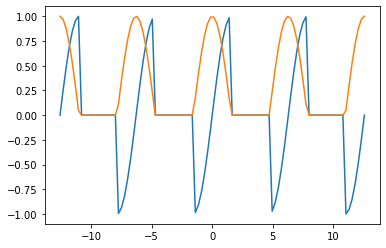

In [240]:
# plt.plot(xs, xs)
# plt.plot(xs, xs % (2*np.pi))
plt.plot(xs, np.sin(mask_phase(xs)))
plt.plot(xs, np.maximum(np.cos(xs), 0))

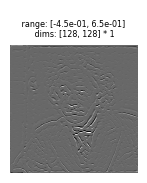

In [204]:
a = lg.activation1[1,1][-1,0]
# plt.hist(po.to_numpy(lgc.direction1[1,1][-1,0]).flatten());
b = lgc.direction1[1,1][-1,0] * (lgc.direction1[1,1][-1,0] < np.pi/2) * (lgc.direction1[1,1][-1,0] > -np.pi/2)
# b = lgc.direction1[1,1][-1,0] * (lgc.direction1[1,1][-1,0] > np.pi/2) * (lgc.direction1[1,1][-1,0] < -np.pi/2)

pt.imshow(po.to_numpy(a * b));

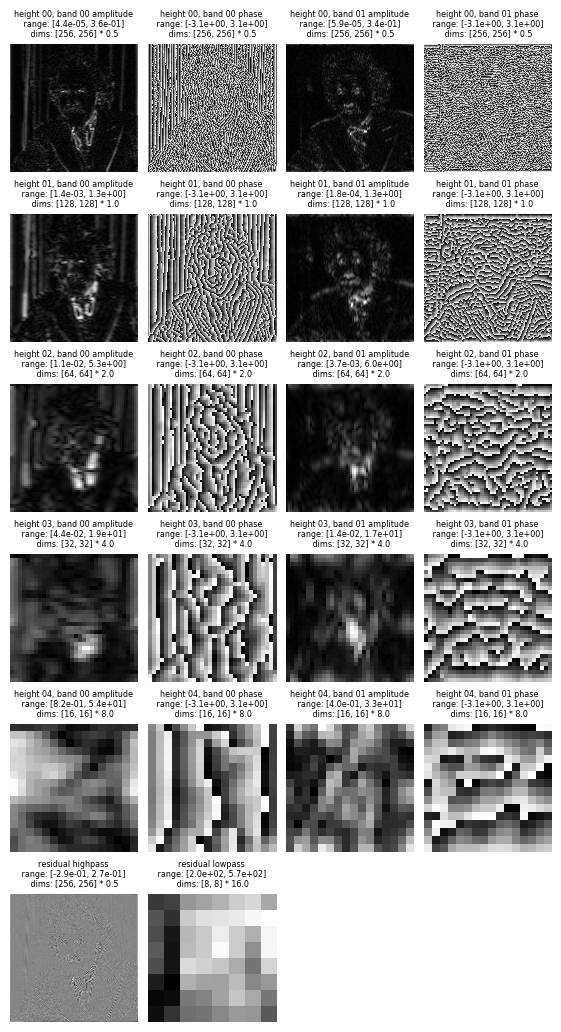

In [127]:
pt.pyrshow(po.convert_pyrshow(lgc.activation1, -1, 0), zoom=.5, plot_complex='polar', col_wrap=4);

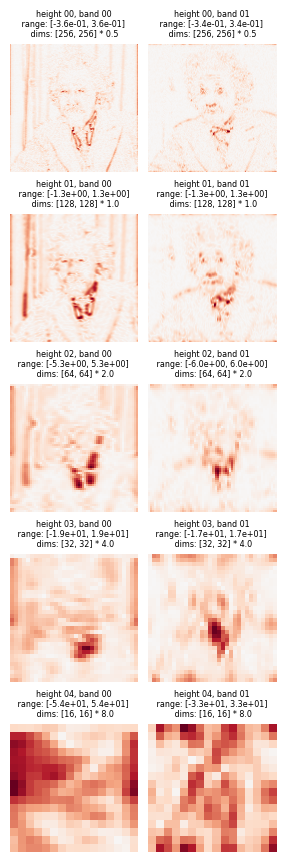

In [99]:
pt.pyrshow(po.convert_pyrshow(yc, -1, 0), zoom=.5, vrange='indep0');
# pt.pyrshow(po.convert_pyrshow(y, -1, 0), zoom=1, vrange='indep0');

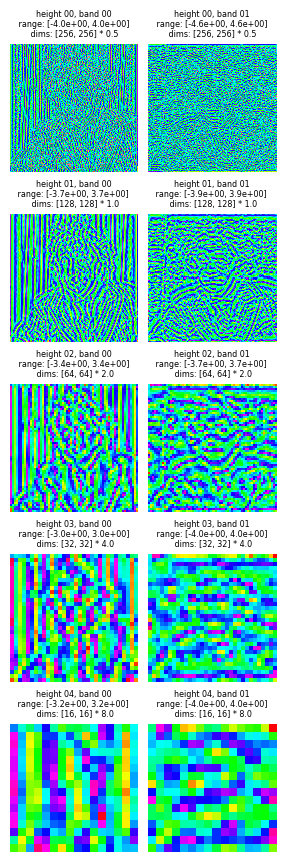

In [100]:
pt.pyrshow(po.convert_pyrshow(lg.direction1, -1, 0), zoom=.5, vrange='indep0', cmap='hsv');

-----

In [ ]:
# 2, 5; 10
# 

In [126]:
[a.shape for a in lgc.activation1.values()]
[n.shape for n in lgc.norm1.values()]
[d.shape for d in lgc.direction1.values()]

[torch.Size([15, 1, 256, 256]),
 torch.Size([15, 1, 256, 256, 2]),
 torch.Size([15, 1, 256, 256, 2]),
 torch.Size([15, 1, 128, 128, 2]),
 torch.Size([15, 1, 128, 128, 2]),
 torch.Size([15, 1, 64, 64, 2]),
 torch.Size([15, 1, 64, 64, 2]),
 torch.Size([15, 1, 32, 32, 2]),
 torch.Size([15, 1, 32, 32, 2]),
 torch.Size([15, 1, 16, 16, 2]),
 torch.Size([15, 1, 16, 16, 2]),
 torch.Size([15, 1, 8, 8])]

In [108]:
import torch.nn.functional as F

In [113]:
y[1,1].shape

torch.Size([15, 1, 64, 64])

In [117]:
Y = F.interpolate(y[1,1], 128, mode='bilinear')

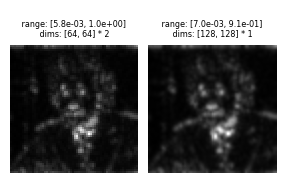

In [124]:
pt.imshow([numpy(y[1,1][-1,0]), numpy(Y[-1,0])]);

In [74]:
image = stimuli[-1:]

e = po.synth.Eigendistortion(image, lg)

In [75]:
distortions = e.synthesize(tol=1e-4, n_steps=100)

out size torch.Size([43648, 1]) in size torch.Size([65536, 1])
implicit power method, computing the maximum distortion
0 [19.220772]
1 [9.549019]
2 [8.331871]
3 [7.951065]
4 [7.033371]
5 [5.9200897]
6 [4.8405914]
7 [3.75589]
8 [2.7157288]
9 [1.8308945]
10 [1.172348]
11 [0.7203903]
12 [0.431839]
13 [0.2518463]
14 [0.14900208]
15 [0.08605957]
16 [0.05023193]
17 [0.03041077]
18 [0.01651764]
19 [0.01052856]
20 [0.00434113]
21 [0.0040741]
22 [0.00224304]
23 [0.00082397]
24 [0.00016022]
25 [0.00077057]
26 [0.00047302]
27 [0.00013733]
28 [0.00047302]
29 [0.00033569]
30 [0.00028229]
31 [0.00029755]
32 [0.00030518]
33 [0.00048065]
34 [2.2888184e-05]
implicit power method, computing the minimum distortion
0 [11.050173]
1 [7.0251904]
2 [4.3453436]
3 [2.809434]
4 [1.9717045]
5 [1.4802332]
6 [1.1569977]
7 [0.9239702]
8 [0.7467861]
9 [0.60881996]
10 [0.5000472]
11 [0.41398287]
12 [0.3456297]
13 [0.29137826]
14 [0.24784899]
15 [0.2130003]
16 [0.18483901]
17 [0.16193128]
18 [0.14319277]
19 [0.1277597]

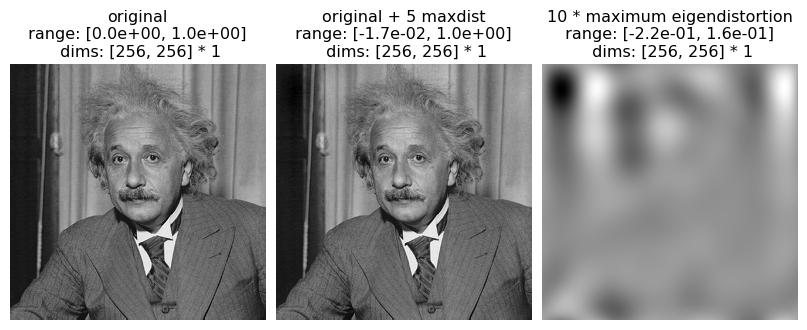

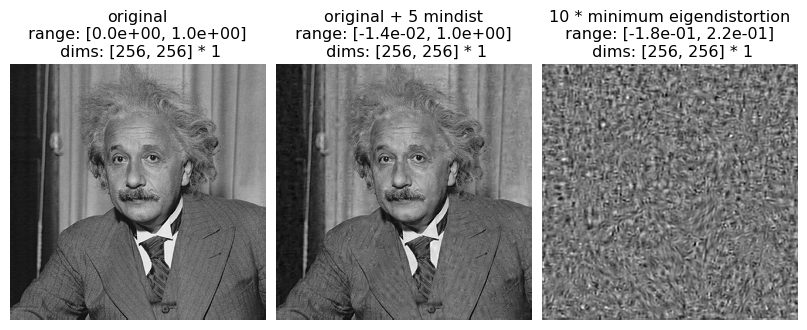

In [76]:
e.display()

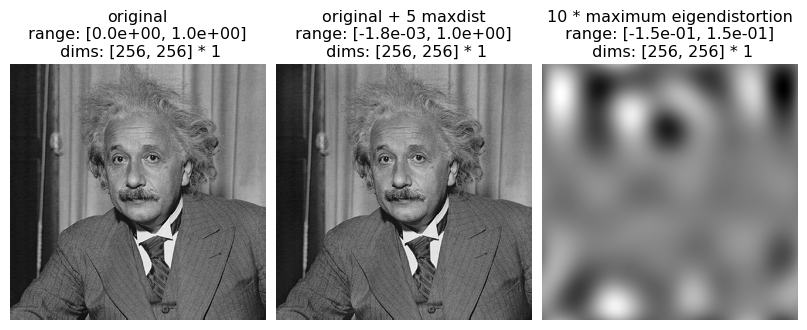

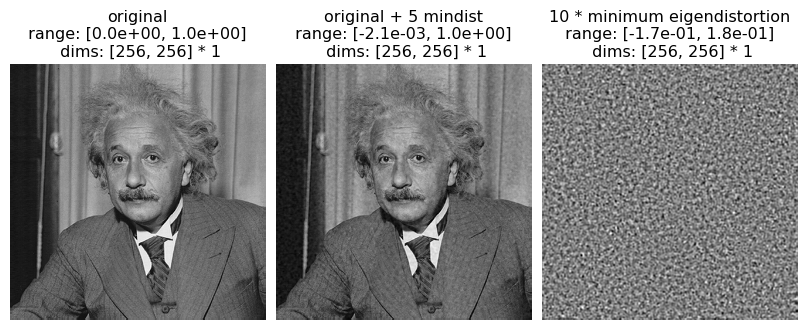

In [73]:
e.display()

In [83]:
m = po.synth.Metamer(image, lgc)

In [86]:
c = po.RangeClamper([0,1])
m.synthesize(max_iter=300, learning_rate=1, seed=1, optimizer='SGD',
                                                     fraction_removed=.1, clamper = c)


100%|██████████| 300/300 [01:21<00:00,  3.68it/s, gradient_norm=1.7728e+00, learning_rate=3.81e-6, loss=7.7533e+01]


(tensor([[6.2845e-01, 3.1098e-01, 3.8044e-01,  ..., 3.9066e-01, 4.0299e-01,
          1.5078e-02],
         [6.1153e-01, 7.1456e-01, 4.8747e-01,  ..., 0.0000e+00, 0.0000e+00,
          3.2037e-01],
         [1.0763e-01, 7.8425e-01, 7.9979e-01,  ..., 2.4891e-01, 4.0026e-04,
          4.4655e-01],
         ...,
         [4.1767e-01, 4.5096e-01, 2.6584e-01,  ..., 2.2571e-01, 4.2648e-01,
          2.3207e-01],
         [1.6541e-01, 6.2548e-02, 5.1720e-01,  ..., 9.0480e-01, 7.8189e-01,
          7.4852e-01],
         [3.9922e-01, 3.4400e-01, 3.6733e-01,  ..., 4.3992e-01, 2.9081e-01,
          6.2144e-01]]),
 tensor([ 0.0983,  0.0656,  0.0473,  ..., 10.8822, 16.0399, 20.3255]))

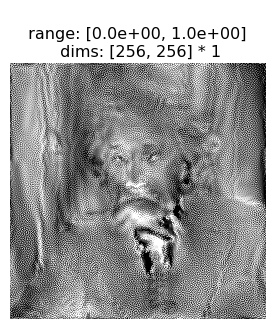

In [87]:
pt.imshow(numpy(m.matched_image));

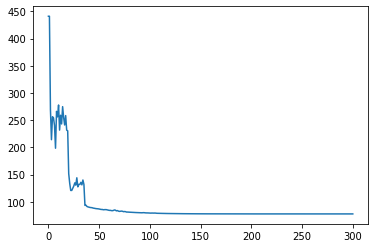

In [88]:
plt.plot(m.loss)